## Ricker Model estimation with approximated likelihood ratios

Juan Pavez, March 2016.

In this notebook we study the usability of the method [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273) for times series parameter estimation.

For this, the Ricker classical populatiol model is used (this model shows near-chaotic dynamics). The ricker model is defined as:
$$ X_{t+1} = rX_t\exp(-X_t + e_t) $$
where $e_t$ is independent with $Normal(0,\sigma^2)$ distribution.
The process is not observed directly, instead samples with poisson distribution are observed.
$$ Y_t = Poisson(\phi X_t) $$
The Ricker model is an example of state space models.
We first only consider the time serie $X$ in order to study parameter estimation using approximated likelihood ratios on time series.
Here, the distribution is only conditioned by the previous value $p(x_t|x_{t-1})$. 
The joint probability distribution is then 
$$p_{x_t,...x_1}(x_t,...x_1;\theta) = \prod_{t=2}^T{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta)} * p_{x_1}(x_1;\theta)$$

or if we keep $x_1$ deterministic, the conditional likelihood can be used instead 
$$\prod_{t=2}^T{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta)}$$ . 

A recurrent neural network trained on the sequences $X' = [{x_t,x_{t-1}}]$ will approximate the posterior probability $p(y_t|x_t,x_{t-1})$ which is monotonic to the ratio $p(x_t|x_{t-1};\theta_0)/ p(x_t|x_{t-1};\theta_1)$

Then to compute the likelihood ratio :
$$\frac{L(\theta_0)}{L(\theta_1)} = \prod_{t=1}^T \frac{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta_0)}{p_{x_t|x_{t-1}}(x_t|x_{t-1};\theta_1)}$$
 we can replace the ratios $p(x_t|x_{t-1};\theta_0)/ p(x_t|x_{t-1};\theta_1)$  by the distribution of the score of the trained RNN $p(s([x_t,x_{t-1}])|\theta_0)/ p(s([x_t,x_{t-1}])|\theta_1)$.
 
Then, we can use maximum likelihood on the approximated likelihood ratios (keeping the ratio fixed) in order to estimate the parameters of the time series model.

We start by estimating the parameter $r$ from $\theta = (r,\sigma^2,\phi)$.



In [74]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import theano
matplotlib.style.use('ggplot')

import os, sys, inspect
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder + '/carl')

np.random.seed(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
def logit(x):
    return np.log(x) - np.log(1-p)
def logistic(x):
    return 1. / (1. + np.exp(-x)) 


In [76]:
r_value = 4.0
sigma_2_value = 0.3**2
phi_value = 5.
r_bkg = 5.
phi_bkg = 8.

shared_r = theano.shared(r_value, name="r")
shared_sigma_2 = theano.shared(sigma_2_value,name="sigma_2")
shared_phi = theano.shared(phi_value, name="phi")

class Ricker:
    def __init__(self,r,sigma_2,phi):
        self.r = r
        self.sigma_2 = sigma_2
        self.phi = phi
    
    def sample(self,r=0.5, sigma_2=1., phi=0.1, start=0.1,n_timesteps=1000, rng=None):
        noise = rng.normal(0.,sigma_2, n_timesteps)
        time_serie = np.zeros(n_timesteps,dtype=np.float64)
        time_serie[0] = np.abs(noise[0])
        r_e = np.exp(r)
        for i in range(1,n_timesteps):
            time_serie[i] = (r_e*time_serie[i-1]*np.exp(-time_serie[i-1] + noise[i]))

        sampled = np.zeros(n_timesteps)
        sampled = np.array([rng.poisson(phi*time_serie[i]) for i in range(0,n_timesteps,1)])
        
        return_serie = np.log(time_serie[1:]/(time_serie[:-1]))
        
        return time_serie.reshape(time_serie.shape[0],1), sampled.reshape(sampled.shape[0],1),return_serie.reshape(return_serie.shape[0],1)
    def rvs(self,n_samples, random_state=1234):
        rng = np.random.RandomState(random_state) if \
                isinstance(random_state,int) else random_state
        return self.sample(r=self.r.eval(),sigma_2=self.sigma_2.eval(),phi=self.phi.eval(),
                     n_timesteps=n_samples,rng=rng)[1]
                
    
#serie1,sampled1 = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)
#serie2,sampled2 = ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)

#X_true,X_true_obs = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=1500,start=0.5)


In [77]:
n_samples = 5000000 # train
test_samples = 1500 # test
hist_samples = 50000 # histograms
n_bins = 15 # histogram construction
max_len = 2
n_sampled = 1
# best results 10000,1500,10000,15,4,100

In [78]:
p0 = Ricker(r=shared_r,sigma_2=shared_sigma_2,phi=shared_phi)
#p1 = Ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.)
p1 = Ricker(r = theano.shared(r_bkg, name="r_1"),
            sigma_2 = theano.shared(0.3**2,name="sigma_2_1"),
            phi = theano.shared(phi_bkg, name="phi_1")
            )
rng = np.random.RandomState(1234)

X_true = p0.rvs(test_samples, random_state=rng)


0 110
0 516


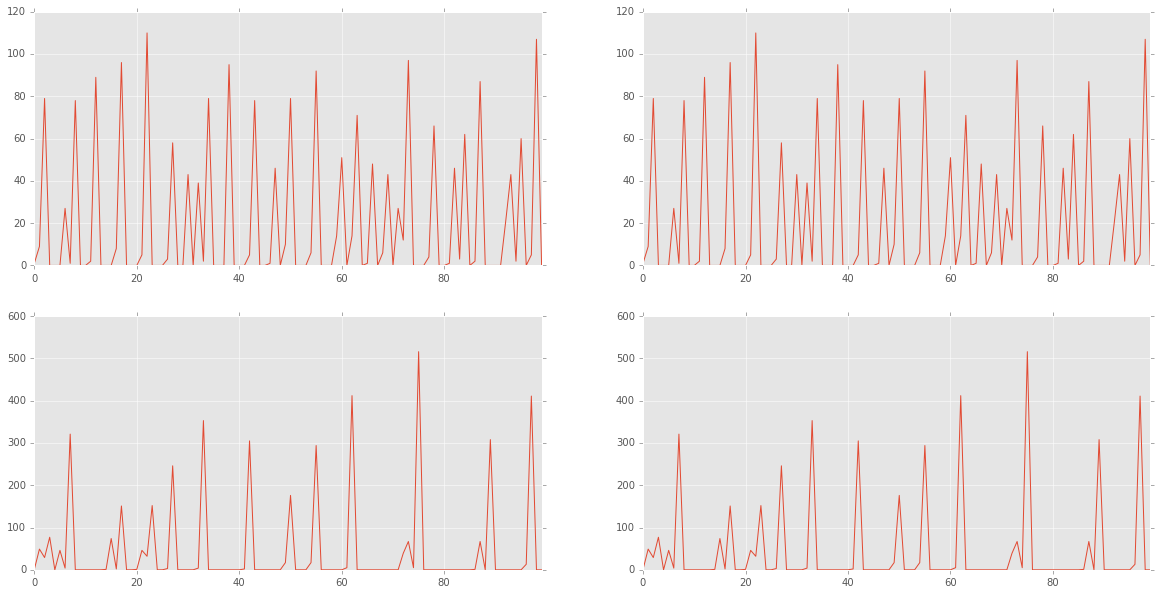

In [79]:
serie1 = p0.rvs(100).ravel()
serie2 = p1.rvs(100).ravel()
plt.figure(figsize=(20,10))
plt.subplot(221)
ts = pd.Series(serie1)
ts[0:100].plot()
plt.subplot(222)
ts = pd.Series(serie1)
ts.plot()
plt.subplot(223)
ts = pd.Series(serie2)
ts[0:100].plot()
plt.subplot(224)
ts = pd.Series(serie2)
ts.plot()
print serie1.min(),serie1.max()
print serie2.min(),serie2.max()

In [80]:
from carl.learning import ParameterStacker

from itertools import product
def make_parametrized_classification_std(p0, p1, n_samples, params, rng):
    if not isinstance(params[0], tuple):
        X0 = p0.rvs(n_samples // 2, random_state=rng)
        X1 = p1.rvs(n_samples - (n_samples // 2), random_state=rng)
        X = ParameterStacker(params).transform(np.vstack((X0, X1)))
        y = np.zeros(n_samples)
        y[len(X0):] = 1

        return X, y

    elif isinstance(params[0], tuple):
        combinations = list(product(*[values for _, values in params]))

        all_X = []
        all_y = []

        for c in combinations:
            for i, v in enumerate(c):
                params[i][0].set_value(v)

            X, y = make_parametrized_classification_std(
                p0, p1,
                n_samples // len(combinations),
                [p for p, _ in params], rng=rng)

            all_X.append(X)
            all_y.append(y)

        X = np.vstack(all_X)
        y = np.concatenate(all_y)

        return X, y

    else:
        raise ValueError

In [81]:
Xs, ys = [],[]
for n in range(n_sampled):
    X, y = make_parametrized_classification_std(
        p0, p1,
        n_samples, 
        [(shared_r, np.linspace(3.3,4.5, num=20)),
        (shared_phi, np.linspace(3.5,7.5,num=20))],
        rng=n)
    Xs.append(X)
    ys.append(y)

In [82]:
print(Xs[0])

[[   0.     3.3    3.5]
 [  16.     3.3    3.5]
 [  14.     3.3    3.5]
 ..., 
 [ 152.     4.5    7.5]
 [   0.     4.5    7.5]
 [   0.     4.5    7.5]]


In [83]:
import pdb
X_series, y_series = [],[]

for n in range(n_sampled):
    X0_serie = []
    y0_serie = []
    X1_serie = []
    y1_serie = []

    X0 = Xs[n][ys[n] == 0]
    X1 = Xs[n][ys[n] == 1]
    for i in xrange(X0.shape[0]-max_len+1):
        # ensure that is from same time serie
        if X0[i][-1] == X0[i+max_len-1][-1] and X0[i][-2] == X0[i+max_len-1][-2]:
            X0_serie.append(X0[i:i+max_len])
        if X1[i][-1] == X1[i+max_len-1][-1] and X1[i][-2] == X1[i+max_len-1][-2]:
            X1_serie.append(X1[i:i+max_len])
    X0_serie = np.array(X0_serie)
    X1_serie = np.array(X1_serie)

    X0_serie = X0_serie[np.random.choice(X0_serie.shape[0],X0_serie.shape[0],replace=False)]
    X1_serie = X1_serie[np.random.choice(X1_serie.shape[0],X1_serie.shape[0],replace=False)]

    X_serie = np.vstack((
         X0_serie,
         X1_serie))
    y_serie = np.zeros(X0_serie.shape[0]*2,dtype=np.int)
    y_serie[X0_serie.shape[0]:] = 1
    
    X_series.append(X_serie)
    y_series.append(y_serie)



In [84]:
print(X0.shape)

(2500000, 3)


In [85]:
X_serie = X_series[0]
y_serie = y_series[0]
for k in range(1,len(X_series)):
    X_serie = np.vstack((X_serie,X_series[k]))
    y_serie = np.hstack((y_serie,y_series[k]))

In [86]:
print(X_serie.shape)

(4999200, 2, 3)


In [87]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM, Dropout
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD, Adam


def make_model():
    model = Sequential()
    model.add(SimpleRNN(10,input_shape=(max_len,X_serie.shape[2])))
    #model.add(Dropout(0.3))
    model.add(Dense(5,activation='tanh'))
    #model.add(Dropout(0.3))
    model.add(Dense(1,activation='sigmoid'))
    #sgd = SGD(lr=0.01, clipnorm=40.)
    adam = Adam(clipnorm=40.)
    model.compile(loss="binary_crossentropy", optimizer=adam)
    return model


clf = KerasClassifier(make_model, nb_epoch=30, verbose=2)
#clf = make_pipeline(StandardScaler(),as_classifier(clf))

clf.fit(X=X_serie, y=y_serie)
#clf.fit(X=X_serie, y=y_serie,nb_epoch=3,batch_size=32,verbose=2)

Epoch 1/30
111s - loss: 0.4132
Epoch 2/30
117s - loss: 0.3993
Epoch 3/30
113s - loss: 0.3982
Epoch 4/30
116s - loss: 0.3975
Epoch 5/30
120s - loss: 0.3968
Epoch 6/30
116s - loss: 0.3962
Epoch 7/30
120s - loss: 0.3959
Epoch 8/30
114s - loss: 0.3958
Epoch 9/30
119s - loss: 0.3956
Epoch 10/30
120s - loss: 0.3955
Epoch 11/30
116s - loss: 0.3954
Epoch 12/30
117s - loss: 0.3954
Epoch 13/30
120s - loss: 0.3953
Epoch 14/30
116s - loss: 0.3954
Epoch 15/30
114s - loss: 0.3952
Epoch 16/30
115s - loss: 0.3952
Epoch 17/30
116s - loss: 0.3952
Epoch 18/30
118s - loss: 0.3952
Epoch 19/30
114s - loss: 0.3952
Epoch 20/30
115s - loss: 0.3952
Epoch 21/30
116s - loss: 0.3952
Epoch 22/30
116s - loss: 0.3952
Epoch 23/30
118s - loss: 0.3952
Epoch 24/30
114s - loss: 0.3952
Epoch 25/30
114s - loss: 0.3952
Epoch 26/30
115s - loss: 0.3951
Epoch 27/30
116s - loss: 0.3952
Epoch 28/30
125s - loss: 0.3952
Epoch 29/30
116s - loss: 0.3952
Epoch 30/30
118s - loss: 0.3952


In [88]:
print clf.predict_proba(X_serie)

[[  9.94059741e-01   5.94028644e-03]
 [  9.99064207e-01   9.35817254e-04]
 [  8.66040111e-01   1.33959904e-01]
 ..., 
 [  1.87032282e-01   8.12967718e-01]
 [  5.44124246e-02   9.45587575e-01]
 [  8.11334014e-01   1.88665986e-01]]


In [89]:
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

cc_direct = ClassifierRatio(
    base_estimator=CalibratedClassifierCV(clf, bins=30, cv='prefit', 
                                         method='histogram'), 
    random_state=0)
cc_direct.fit(X=X_serie,y=y_serie)

ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x2121af50>,
            bins=30, cv='prefit', method='histogram'),
        random_state=0)

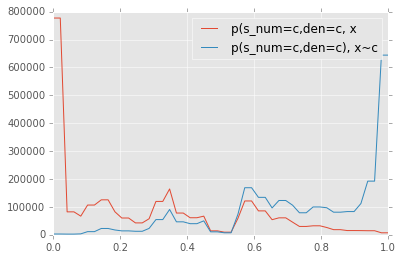

In [90]:
reals2 = np.linspace(0, 1)

cal_num, cal_den = cc_direct.classifier_.calibrators_[0].calibrators
plt.plot(reals2, cal_num.pdf(reals2.reshape(-1, 1)), 
         label="p(s_num=c,den=c, x")
plt.plot(reals2, cal_den.pdf(reals2.reshape(-1, 1)), 
        label="p(s_num=c,den=c), x~c")
plt.legend()
plt.show()


In [91]:

from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio
import pdb

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

def objective(theta, random_state=0, X_true=None):    
    #print(theta)
    shared_r.set_value(theta[0])
    shared_phi.set_value(theta[1])
    serie1 = p0.rvs(hist_samples)
    #serie1 = (serie1 - serie1.mean()) / serie1.std()
    # Set parameter values   
    X0 = np.zeros((serie1.shape[0],serie1.shape[1]+2))
    X0[:,:-2] = serie1
    X0[:,-2] = theta[0]
    X0[:,-1] = theta[1]
    
    # Fit ratio
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=40))

    serie2 = p1.rvs(hist_samples,random_state=random_state)
    #serie2 = (serie2 - m1) / s1
    X1 = np.zeros((serie2.shape[0],serie2.shape[1]+2))
    X1[:,:-2] = serie2
    #X1[:,-2] = r_bkg
    #X1[:,-1] = phi_bkg
    X1[:,-2] = theta[0]
    X1[:,-1] = theta[1]

    X0_serie = []
    X1_serie = []

    for i in xrange(serie1.shape[0]-max_len):
        X0_serie.append(X0[i:i+max_len])
        X1_serie.append(X1[i:i+max_len])
    X0_serie = np.array(X0_serie)
    X1_serie = np.array(X1_serie)
    X0_serie = X0_serie[np.random.choice(X0_serie.shape[0],X0_serie.shape[0],replace=False)]
    X1_serie = X1_serie[np.random.choice(X1_serie.shape[0],X1_serie.shape[0],replace=False)]

    X_serie = np.vstack((
         X0_serie,
         X1_serie))
    y_serie = np.zeros(X0_serie.shape[0]*2,dtype=np.int)
    y_serie[X0_serie.shape[0]:] = 1
    
    ratio.fit(X_serie, y_serie)
    
    # Evaluate log-likelihood ratio
    X_true_ = np.zeros((X_true.shape[0],X_true.shape[1]+2))
    X_true_[:,:-2] = X_true
    X_true_[:,-2] = theta[0]
    X_true_[:,-1] = theta[1]
    
    X_true_serie = []
    for i in xrange(X_true_.shape[0]-max_len):
        X_true_serie.append(X_true_[i:i+max_len])
    X_true_serie = np.array(X_true_serie)
    X_true_serie = X_true_serie[np.random.choice(X_true_serie.shape[0],X_true_serie.shape[0],
                                                replace=False)]
    
    r = ratio.predict(X_true_serie, log=True)
    zeros = r[np.isinf(r)].shape
    #print r[np.isfinite(r)].shape
    #value = -np.mean(r[np.isfinite(r)])  # optimization is more stable using mean
                                         # this will need to be rescaled by len(X_true)
    
    #r[np.isinf(r)] = 0.
    value = -np.mean(r[np.isfinite(r)])
    #print zeros
    #print value

    return value, zeros[0]


In [92]:

# Contours of the approximated LR
shared_r.set_value(r_value)
shared_phi.set_value(phi_value)

bounds = [(3.7,4.3),
          (3.5,7.)]

As = np.linspace(bounds[0][0],bounds[0][1], 10)
Bs = np.linspace(bounds[1][0],bounds[1][1], 10)
AA, BB = np.meshgrid(As, Bs)
X = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))

In [93]:
approx_contours = np.zeros(len(X))
zeros = np.zeros(len(X))
X_true = p0.rvs(20000, random_state=np.random.randint(0,5000))

i = 0
for a in As:    
    for b in Bs:
        approx_contours[i],zeros[i] = objective([a, b],X_true=X_true) 
        i += 1
        
approx_contours = 2. * (approx_contours - approx_contours.min()) * len(X_true)

In [94]:
approx_contours

array([ 72745.8646302 ,  56047.26532212,  42482.18073009,  27800.68594664,
        17257.56116296,  10157.45147433,   6350.97991256,   4178.25642289,
         4114.09089098,   4554.2781257 ,  60576.0337316 ,  46044.22973919,
        30958.04917911,  18138.43414869,  10245.90360889,   5620.50686725,
         2838.42293214,   2081.72422746,   2054.29912691,   3287.11212828,
        54975.2275278 ,  32709.04704691,  20110.96139456,  10644.76833853,
         5466.41223513,   2232.76646028,   1313.6266897 ,   1368.3314833 ,
         2160.45309021,   3832.46312895,  41903.19945593,  24460.79761325,
        12031.97112438,   6036.68642125,   2452.1560769 ,   1173.50563167,
          638.58230384,   1272.70713727,   2927.82029478,   4758.22294466,
        28984.30508126,  15029.60169659,   6920.71971284,   2151.94797786,
         1408.1540742 ,    681.69822959,    948.52616929,   2395.81519462,
         4374.4686768 ,   6400.53162221,  20575.90417605,   9204.81819076,
         3219.42939891,  

(4.0333333333333332, 5.0555555555555554) 

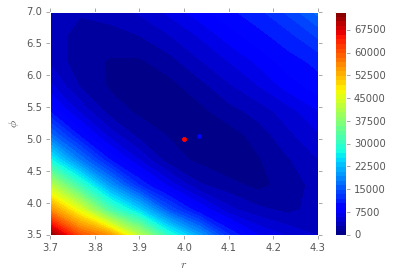

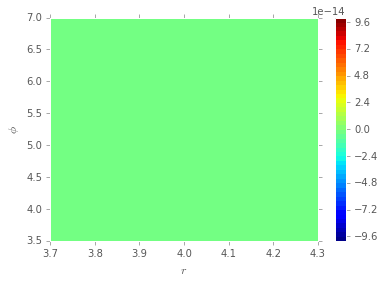

In [95]:
from scipy.stats import chi2
import pdb

min_value = np.unravel_index(approx_contours.argmin(),
            (10,10))
min_position = (As[min_value[0]],Bs[min_value[1]])
print '{0} '.format(min_position),
#plt.contour(As, Bs, approx_contours.reshape(AA.shape).T, 
#            levels=[chi2.ppf(0.683, df=2), 
#                    chi2.ppf(0.9545, df=2),
#                    chi2.ppf(0.9973, df=2)], colors=["w"])
plt.contourf(As, Bs, approx_contours.reshape(AA.shape).T, 50)
plt.colorbar()

plt.plot([r_value], [phi_value], "r.", markersize=8)
plt.plot([r_value], [phi_value], "r.", markersize=8)
plt.plot([min_position[0]], [min_position[1]], "b.", markersize=8)


plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
plt.xlabel(r"$ r$")
plt.ylabel(r"$\phi$")

#plt.savefig("fig4c.pdf")
plt.show()

plt.contourf(As, Bs, zeros.reshape(AA.shape).T, 50)
plt.colorbar()

plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
plt.xlabel(r"$ r$")
plt.ylabel(r"$\phi$")
plt.show()

In [96]:
n_hist = 30
hist_values = np.zeros((n_hist,2))
approx_contours = np.zeros(len(X))


for h in range(n_hist):
    shared_r.set_value(r_value)
    shared_phi.set_value(phi_value)
    random_state = np.random.randint(0,5000)
    print(random_state)
    X_true = p0.rvs(500,random_state=random_state)
    zeroes = np.zeros(len(X))
    i = 0
    for a in As:    
        for b in Bs:
            approx_contours[i],zeros[i] = objective([a, b],X_true=X_true) 
            i += 1
        
    approx_contours = 2. * (approx_contours - approx_contours.min()) * len(X_true)
    min_value = np.unravel_index(approx_contours.argmin(),
                (10,10))
    min_position = (As[min_value[0]],Bs[min_value[1]])
    print '{0} '.format(min_position),
    hist_values[h] = min_value
#approx_contours = 2. * (approx_contours - approx_contours.min()) * len(X_true)


2441
(4.0333333333333332, 5.0555555555555554)  3520
(4.0333333333333332, 5.0555555555555554)  3853
(4.0999999999999996, 4.666666666666667)  3241
(3.8999999999999999, 5.8333333333333339)  806
(3.8999999999999999, 5.8333333333333339)  2890
(4.0333333333333332, 5.0555555555555554)  1887
(4.0333333333333332, 5.0555555555555554)  2866
(3.9666666666666668, 5.8333333333333339)  1016
(4.0999999999999996, 5.0555555555555554)  2207
(4.0333333333333332, 5.0555555555555554)  2936
(4.0333333333333332, 5.0555555555555554)  4430
(4.0999999999999996, 4.666666666666667)  1228
(4.0333333333333332, 5.0555555555555554)  3534
(4.0999999999999996, 4.666666666666667)  801
(4.0999999999999996, 4.666666666666667)  206
(4.0999999999999996, 4.666666666666667)  2118
(4.0333333333333332, 5.0555555555555554)  1247
(4.0999999999999996, 4.666666666666667)  3366
(4.0333333333333332, 5.0555555555555554)  1886
(4.0999999999999996, 4.666666666666667)  2119
(4.0999999999999996, 4.666666666666667)  1486
(4.0999999999999996

In [97]:
min_positions = np.array([[As[min_val[0]],Bs[min_val[1]]] for min_val in hist_values])
print('Min position: {0} +- {1}'.format(min_positions[:,0].mean(), min_positions[:,0].std()))
print('Min position: {0} +- {1}'.format(min_positions[:,1].mean(), min_positions[:,1].std()))

Min position: 4.02666666667 +- 0.0813770374382
Min position: 5.10740740741 +- 0.446046495328


/afs/cern.ch/user/j/jpavezse/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


[ 5.05555556  5.05555556  4.66666667  5.83333333  5.83333333  5.05555556
  5.05555556  5.83333333  5.05555556  5.05555556  5.05555556  4.66666667
  5.05555556  4.66666667  4.66666667  4.66666667  5.05555556  4.66666667
  5.05555556  4.66666667  4.66666667  4.66666667  6.22222222  4.66666667
  5.83333333  5.05555556  5.05555556  5.05555556  5.44444444  5.83333333]


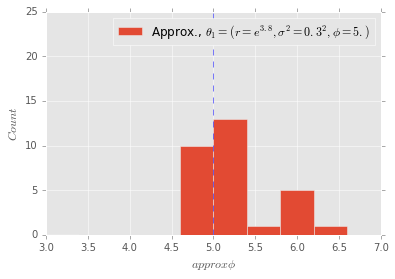

In [98]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#print gp_ratios
print(min_positions[:,1])
ax.hist(min_positions[:,1], range=(3.,7.), 
        label=r"Approx., $\theta_1=(r=e^{3.8},\sigma^2=0.3^2,\phi=5.)$", bins=10)
ax.set_xlabel(r"$approx \phi$")
ax.set_ylabel(r"$Count$")
#plt.legend()

ax.legend()
ax.set_ylim(0., 25.)
#ax.set_xlim(bounds[0][0],bounds[0][1])
ax.axvline(x=phi_value,linestyle='dashed',alpha=0.5)
plt.savefig('likelihood_comp.pdf')
plt.show()

TO-DO:
* 2D parameter estimation.
* Parameter estimation on $Y_t$ (here the method must be adapted for state space models).

* Check with other parameters
* Try with an easier model e.g simple autoregresive model

In [99]:
As[min_value[0]],Bs[min_value[1]]


(3.8999999999999999, 5.8333333333333339)